## Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing annotated browser screenshots for each turn, then choosing the next step to take. The agent architecture is a basic reasoning and action (ReAct) loop. 
The unique aspects of this agent are:
- It's usage of [Set-of-Marks](https://som-gpt4v.github.io/)-like image annotations to serve as UI affordances for the agent
- It's application in the browser by using tools to control both the mouse and keyboard

The overall design looks like the following:

<!-- ![Voyager Image](./img/web-voyager.excalidraw.png) -->
<img src="./img/web-voyager.excalidraw.png" width="50%">


## Configure environment

We will first set up LangSmith tracing. Though optional, this lets us inspect and debug agent's trajectory for a given input.

You can sign up at [smith.langchain.com](https://smith.langchain.com/) to get an API key.

In [3]:
import sys 
sys.path.append('/home/shubharthak/miniconda3/lib/python3.11/site-packages')

In [4]:
# Optional: add tracing to visualize the agent trajectories
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
# _getpass('LANGCHAIN_API_KEY')
# _getpass('OPENAI_API_KEY')


#### Install Agent requirements

The only additional requirement we have is the [playwright](https://playwright.dev/) browser. Uncomment and install below:

In [5]:
# %pip install --upgrade --quiet  playwright > /dev/null
# !playwright install

In [6]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define Graph State

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [7]:
import sys 
sys.path.append('/home/shubharthak/miniconda3/lib/python3.11/site-packages')

In [8]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

## Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [9]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    res = await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

## Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action


Let's first define the annotation step:
#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [10]:
import requests
import base64
import os 

In [11]:
api_key = '2e1356a68253f38d86bc742d6d57d4e3'

In [12]:
def convert_image_to_base64(image_path):
    with open(image_path, "rb") as file:
        encoded_string = base64.b64encode(file.read()).decode('utf-8')
    return encoded_string

In [13]:
def upload_image_to_imgbb(base64_image, api_key):
    url = "https://api.imgbb.com/1/upload"
    payload = {
        "key": api_key,
        "image": base64_image
    }
    response = requests.post(url, payload)
    if response.status_code == 200:
        image_url = response.json()["data"]["url"]
        return image_url
    else:
        print("Failed to upload image. Status code:", response.status_code)
        return None

In [14]:
import asyncio
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot(path='screenshot.png')
#     filename = 'screenshot.png'
#     screenshot = convert_image_to_base64(filename)
#     screenshot = upload_image_to_imgbb(screenshot, api_key)
    print('type', type(screenshot))
    print('url', screenshot)

    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img":  base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [15]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [16]:
# import google.generativeai as genai
# genai.configure(api_key=key, transport="rest", )
# llm = ChatGoogleGenerativeAI(model='gemini-pro-vision', temperature=0.0, google_api_key=key)

In [32]:
system_msg = '''
Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will
feature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual
information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow
the guidelines and choose one of the following actions:

1. Click a Web Element.
2. Delete existing content in a textbox and then type content.
3. Scroll up or down.
4. Wait 
5. Go back
7. Return to google to start over.
8. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack
- Google
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *
1) Execute only one action per iteration.
2) When clicking or typing, ensure to select the correct bounding box.
3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.

* Web Browsing Guidelines *
1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
2) Select strategically to minimize time wasted.

Your reply should strictly follow the format:

Thought: {Your brief thoughts (briefly summarize the info that will help ANSWER)}
Action: {One Action format you choose}
Then the User will provide:
Observation: {A labeled screenshot Given by User}
'''

In [18]:
# image_message = {
#     "type": "image_url",
#     "image_url": {"url": img},
# }
# text_message = {
#     "type": "text",
#     "text": '''
#     Valid Bounding Boxes:
# 0 (<a/>): "Gmail (opens a new tab)"
# 1 (<a/>): "Search for Images (opens a new tab)"
# 2 (<a/>): "Google apps"
# 3 (<span/>): "Sign in"
# 4 (<iframe/>): ""
# 5 (<textarea/>): "Search"
# 6 (<div/>): ""
# 7 (<path/>): ""
# 8 (<circle/>): ""
# 9 (<input/>): "Google Search"
# 10 (<input/>): "I'm Feeling Lucky"
# 11 (<a/>): "हिन्दी"
# 12 (<a/>): "বাংলা"
# 13 (<a/>): "తెలుగు"
# 14 (<a/>): "मराठी"
# 15 (<a/>): "தமிழ்"
# 16 (<a/>): "ગુજરાતી"
# 17 (<a/>): "ಕನ್ನಡ"
# 18 (<a/>): "മലയാളം"
# 19 (<a/>): "ਪੰਜਾਬੀ"
# 20 (<a/>): "About"
# 21 (<a/>): "Advertising"
# 22 (<a/>): "Business"
# 23 (<a/>): "How Search works"
# 24 (<a/>): "Privacy"
# 25 (<a/>): "Terms"
# 26 (<div/>): "Settings"
# Could you explain the WebVoyager paper (on arxiv)?
#     ''',
# }
# msg= HumanMessage([text_message, image_message])

# sys = SystemMessage([text_message, image_message])


In [19]:
# import base64
# from io import BytesIO

# from IPython.display import HTML, display
# from PIL import Image


# def convert_to_base64(pil_image):
#     """
#     Convert PIL images to Base64 encoded strings

#     :param pil_image: PIL image
#     :return: Re-sized Base64 string
#     """

#     buffered = BytesIO()
#     pil_image.save(buffered, format="JPEG")  # You can change the format if needed
#     img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
#     return img_str


# def plt_img_base64(img_base64):
#     """
#     Disply base64 encoded string as image

#     :param img_base64:  Base64 string
#     """
#     # Create an HTML img tag with the base64 string as the source
#     image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
#     # Display the image by rendering the HTML
#     display(HTML(image_html))


# file_path = "/home/shubharthak/Desktop/pic.jpeg"
# pil_image = Image.open(file_path)

# image_b64 = convert_to_base64(pil_image)
# plt_img_base64(image_b64)

In [48]:
from langchain.schema import HumanMessage
from langchain_community.chat_models import ChatOllama
llm = ChatOllama(model="llava:13b", temperature=0, system=system_msg)

# from langchain_core.output_parsers import StrOutputParser
# chain = prompt_func | llm | StrOutputParser()

# query_chain = chain.invoke(
#     {"text": "Describe the image: ", "image": image_b64}
# )
# print(query_chain)



In [42]:
from langchain_community.llms import Ollama
llm = Ollama(model='llava:latest', temperature=0, system=system_msg)

In [22]:
# agent = annotate()

In [23]:
# from langchain_google_vertexai import VertexAI

# llm = VertexAI(model_name="gemini-pro-vision")



In [46]:
from IPython.display import Markdown

In [47]:
Markdown(system_msg)


Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will
feature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual
information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow
the guidelines and choose one of the following actions:

1. Click a Web Element.
2. Delete existing content in a textbox and then type content.
3. Scroll up or down.
4. Wait 
5. Go back
7. Return to google to start over.
8. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack
- Google
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *
1) Execute only one action per iteration.
2) When clicking or typing, ensure to select the correct bounding box.
3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.

* Web Browsing Guidelines *
1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
2) Select strategically to minimize time wasted.

Your reply should strictly follow the format:

Thought: {Your brief thoughts (briefly summarize the info that will help ANSWER)}
Action: {One Action format you choose}
Then the User will provide:
Observation: {A labeled screenshot Given by User}


In [24]:
# llm = Ollama(model='llava:latest')
# llm = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096)
# llm = 
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

In [25]:
# s = prompt | llm
# 

## Define graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [26]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [27]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## Run agent

Now that we've created the whole agent executor, we can run it on a few questions! We'll start our browser at "google.com" and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [49]:
import playwright
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        print('yo')
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Wait: None
2. retry: Could not parse LLM Output:  The image you've provided appears to be a screenshot of a web browser with the Google homepage displayed. The browser is showing a variety of search results for different languages, as indicated by the language options at the top right corner.

The user interface elements visible in the screenshot include:

1. A search bar where you can type your query.
2. A list of suggested searches on the left side of the page, which includes options like "Gmail (opens a new tab)" and "Google apps."
3. The Google logo at the top center of the page.
4. A navigation menu with links to various Google services such as "Search," "Images," "News," etc.
5. A settings icon in the bottom right corner, which is typically used to access user preferences or account settings.
6. A language selection dropdown menu at the top right corner of the page.
7. The Google Chrome browser interface elements like the address bar and the back button.
8. Some bookmarks or f

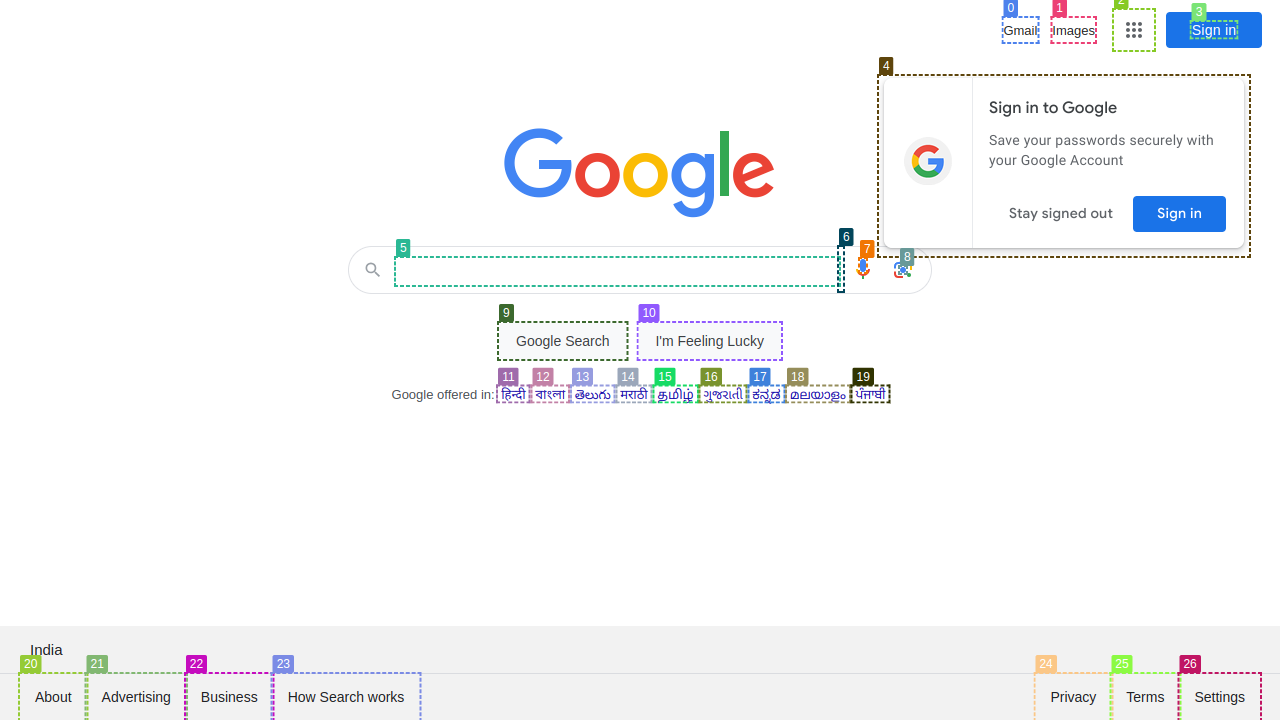

type <class 'bytes'>
url b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x00\x00\x00\x02\xd0\x08\x06\x00\x00\x00\xcf}\xddV\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00 \x00IDATx\x9c\xec\xddyX\xd5e\xfa\xc7\xf1\xf7\xd98\x07\x14\x10\x11Wp\xdf\xf7}-\xb7\xb2}\xda\xb3i\xcc\xc9ij\xaa\x99~m\xce\xa8c\x9b\xb6\x98Y6\xd6\xd8^f\x99\xb9fniY\x99\xbb\xb9\x81\x9a:\x8a;\xe0\x06(\xb2\x9f\xc3\xd9~\x7f\x00G\x11T@\xf0\x80~^\xd7\xc5uq\x9e\xefv\x7f\xbf\xe0\x11n\xee\xe7\xb9\r^\xaf\xd7\x8b\x88\x88\x88\x88\x88\x88\x88T\x18\xce\xb8\r8\xf7\xfcT\xe2\xe3\x0c\x01A\x04\xf6{\xae\\b*\xa9\xc4%\xf1\x1c\xf9jo\x89\x8f3\x87\x04\xd0\xee\x93k\xca%\xa6\xcbaDh\\\x11\xa3\x06\xea\xfd5\x9c\xa1O\x1aX\xf5p2\xebb\n\xa7b\x06\xfd;\x94A\xa3B/K\x8cr\xf51\xfb;\x00\x11\x11\x11\x11\x11\x11\x119\x87\xcbQ\xaa\xc3\xbc9Ye\x1eJiy\xb2\\\xa5:\xce\x95\x96S\xe6\xb1\xf8[\xf5\x07\xc3\x19\xfa\x88\x97\x1f\xefI&\xe6\x80\xbf\xa3\x91\xab\x91\x12\x80""""""""\xe5\xa5q0\xf7\x8e4\xb1\xee\xfe\x13J\xfe\x89\xdf(\x01(""""""R\x19\x98#\xb1\xb4\xb9\rsx5\x0c\xee\x
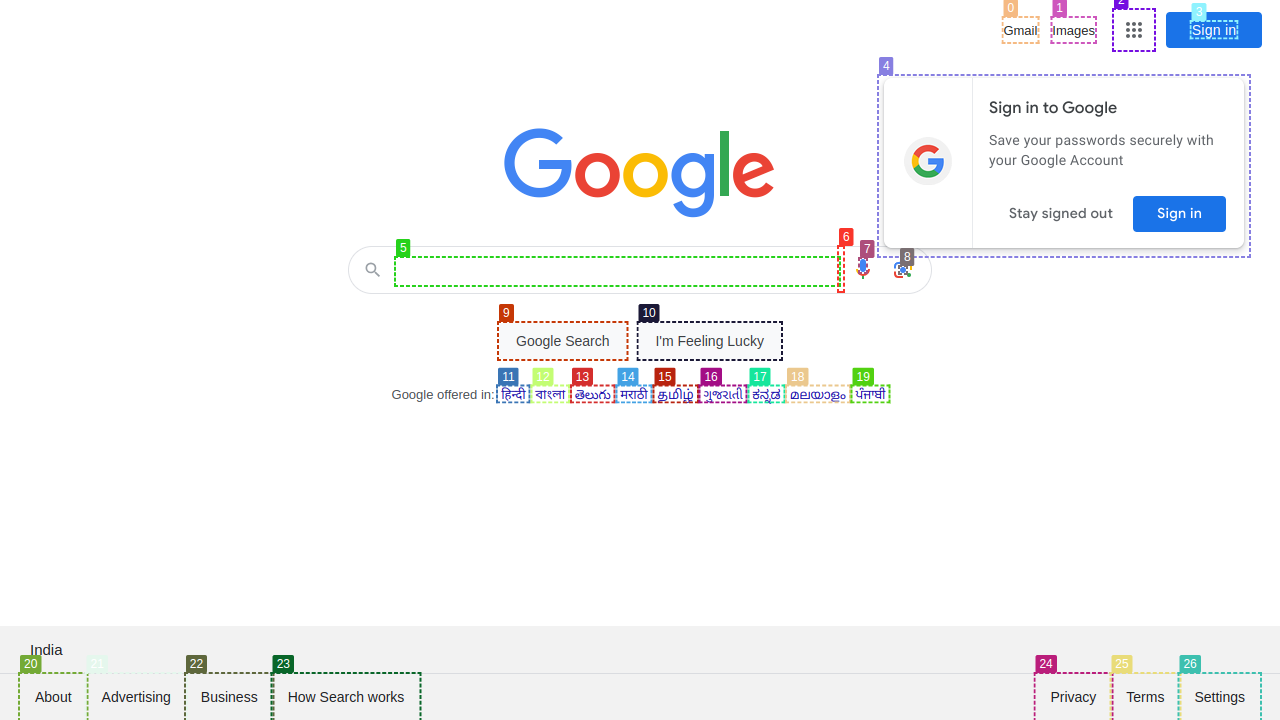
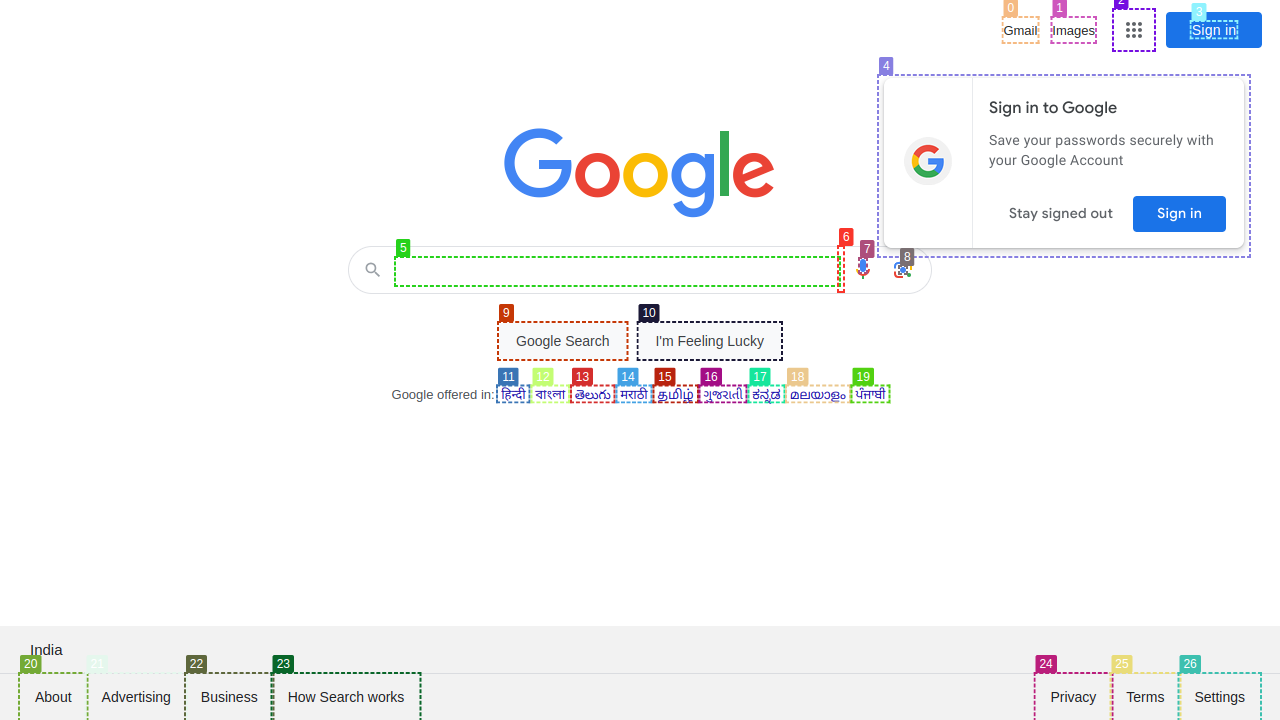

CancelledError: 

In [50]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page)
print(f"Final response: {res}")

In [ ]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

In [ ]:
res = await call_agent("What are the latest blog posts from langchain?", page)
print(f"Final response: {res}")

In [ ]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown.",
    page,
)
print(f"Final response: {res}")